# Tutorial: Cross-Lingual Evolutionary Merging with Mergenetic

In this notebook we demonstrate how to set up and run a cross-lingual evolutionary merging experiment using the Mergenetic library. 

The notebook follows these steps:

1. **Data Loading:** Load the dataset from a CSV file.
2. **Anchor Extraction:** Randomly sample anchor points from the data.
3. **Model Evaluation:** Evaluate the base models to obtain their responses.
4. **Theta Retrieval:** Retrieve latent ability parameters (thetas).
5. **Accuracy Estimation Setup:** Configure the parameters used for accuracy estimation.
6. **Dataset Splitting:** Create a sampled dataset (using anchors) and a test set.
7. **Merger Definition:** Define the merger (using, for example, `SlerpMerger`).
8. **Problem Definition:** Wrap the merging process in an optimization problem (`AnchoredCrossLingualMathProblem`).
9. **Algorithm Setup:** Define a Genetic Algorithm (GA) with appropriate operators.
10. **Searcher and Execution:** Run the evolutionary search and test the merged model.

Let's get started!

In [11]:
# Step 0: Import required modules
import sys
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling

from mergenetic import PROJECT_ROOT
from mergenetic.evaluation import *
from mergenetic.utils import *
from mergenetic.merging.merger import *
from mergenetic.merging import SlerpMerger, TiesDareMerger
import argparse
import pandas as pd
from mergenetic.optimization import (
    MergingProblem,
    ConfigCrossLingual,
    ConfigMultiLingual,
    AnchoredCrossLingualMathProblem,
)
from mergenetic.searcher import Searcher
from dataclasses import dataclass
import yaml
import pickle

# from end2end_utils import *

print("Modules imported successfully.")

Modules imported successfully.


## Configuration Setup

As with any experiment, you need a configuration. In a script you might load a YAML file or use command-line arguments. Here, we define a sample configuration dictionary (which is then used to create a `ConfigCrossLingual` object). Adjust the paths and parameters as needed.

In [12]:
config = ConfigCrossLingual(
    pop_size=1,  # int
    n_iter=1,  # int
    tb_data_path="/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/tb_data/tinybenchmark_20_420.pickle",  # str
    thetas_paths=[  # List[str]
        "/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/romanian_math/results/ft_ro_theta.pkl",
        "/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/romanian_math/results/metamath_ro_theta.pkl",
    ],
    ft_model_paths=[
        "/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/models/base/OpenLLM-Ro/RoMistral-7b-Instruct",
        "/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/models/base/meta-math/MetaMath-Mistral-7B",
    ],
    path_to_store_merged_model="/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/models/merged/",  # str
    path_to_store_yaml="/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/romanian_math/",  # str
    dtype="float16",  # str
    run_id="romanian_math_gmpirt",  # str
    dataset_path="/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/data/new_datasets/gsm8k/gsm8k_test_romanian.csv",  # str
    bench="gsm8k",  # str
    mode="gmpirt",  # str
    seed=420,  # int
    # Optional parameters
    device="cuda:0",  # str | None
    # Optional Extraction parameters
    n_clusters=20,  # int, default=0
    # Optional Evaluation parameters
    ft_model_to_evaluate=["", ""],  # List[str], default=[]
    eval_task="MATH",  # str, default=""
    output_path_evaluation=["", ""],  # List[str], default=[]
    eval_batch_size=64,  # int, default=8
    # Optional Theta Estimation parameters
    responses_path=["", ""],  # List[str], default=[]
    output_path_theta_estimation=[  # List[str], default=[]
        "/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/results/ft_ro_theta.pkl",
        "/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/results/metamath_ro_theta.pkl",
    ],
)

## Step 2: Load the Data

We load the dataset using `pandas`. Ensure the CSV file exists at the specified path.

In [13]:
# Load the dataset
df = pd.read_csv(config.dataset_path)
print("STEP 1 completed: Data loaded")
print(f"Data shape: {df.shape}")

STEP 1 completed: Data loaded
Data shape: (1319, 2)


## Step 3: Extract Random Anchor Points

We sample anchor points from the dataset. These anchors will be used to estimate model performance.

In [14]:
# Extract random anchor points
anchors = df.sample(n=config.n_clusters, random_state=config.seed).index
anchors_weights = (1.0 * np.ones(len(anchors))) / len(anchors)

print("STEP 2 completed: Anchors extracted")
print(f"Anchors: {anchors.tolist()}")

STEP 2 completed: Anchors extracted
Anchors: [594, 153, 384, 679, 43, 562, 1030, 48, 890, 311, 493, 837, 669, 505, 45, 340, 1115, 474, 454, 1089]


## Step 4: Evaluate Base Models

This step calls `evaluate_model()` to obtain predictions from the base models. These predictions are used later in the merging process.

In [15]:
# Evaluate base models to get predictions
predictions = evaluate_model(config)
print("STEP 3 completed: Predictions obtained")

# Evaluation configuration:  ConfigCrossLingual(pop_size=1, n_iter=1, tb_data_path='/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/tb_data/tinybenchmark_20_420.pickle', thetas_paths=['/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/romanian_math/results/ft_ro_theta.pkl', '/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/romanian_math/results/metamath_ro_theta.pkl'], ft_model_paths=['/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/models/base/OpenLLM-Ro/RoMistral-7b-Instruct', '/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/models/base/meta-math/MetaMath-Mistral-7B'], path_to_store_merged_model='/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/models/merged/', path_to_store_yaml='/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/romanian_math/', dtype='float16', run_id='romanian_math_gmpirt', dataset_path='/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/data/new_datasets/gsm8

## Step 5: Retrieve the Thetas

The latent ability parameters (thetas) are obtained using `retrieve_thetas()`. These parameters will be used in the accuracy estimation.

In [16]:
# Retrieve the thetas
thetas = retrieve_thetas(config)
print("STEP 4 completed: Thetas obtained")

STEP 4 completed: Thetas obtained


## Step 6: Set Accuracy Estimation Parameters

We unpack key parameters and set up the accuracy estimation parameters using `AccuracyEstimationParameters`.

In [17]:
# Unpack parameters and set accuracy estimation parameters
pop_size = config.pop_size
n_iter = config.n_iter
run_id = config.run_id
bench = config.bench
mode = config.mode

est_parameters = AccuracyEstimationParameters(
    thetas=thetas,
    sample_weights=anchors_weights,
    sample_ids=anchors,
    bench=bench,
    mode=mode,
)

print("STEP 5 completed: Accuracy estimation parameters set")

STEP 5 completed: Accuracy estimation parameters set


## Step 7: Split the Data

We create the sampled dataset using the anchor indices and define the test set by removing the anchors.

In [18]:
# Create sampled and test sets
sampled_df = df.loc[anchors].copy()
test_df = df.drop(anchors)

print("STEP 6 completed: Samples extracted")
print(f"Sampled data shape: {sampled_df.shape}")
print(f"Test data shape: {test_df.shape}")

STEP 6 completed: Samples extracted
Sampled data shape: (20, 2)
Test data shape: (1299, 2)


## Step 8: Define the Merger

We now define the merger. In this example, we use the `SlerpMerger`, passing in the base model and a finetuned model, as well as other necessary parameters such as layer ranges and paths to store configurations and merged models.

In [19]:
# Define the merger
merger = SlerpMerger(
    run_id=run_id,
    path_to_base_model=config.ft_model_paths[0],
    path_to_model_1=config.ft_model_paths[1],
    path_to_store_yaml=config.path_to_store_yaml,
    path_to_store_merged_model=config.path_to_store_merged_model,
    dtype=config.dtype,
    layer_range_base_model=[0, 32],
    layer_range_model_1=[0, 32],
)

device = config.device if config.device else "cuda"
print("STEP 7 completed: Merger defined")

STEP 7 completed: Merger defined


## Step 9: Define the Optimization Problem

Next, we wrap the merging operation into an optimization problem using `AnchoredCrossLingualMathProblem`. This problem takes the sampled data, test set, merger, and evaluation settings. We then set the accuracy estimation parameters for the problem.

In [20]:
# Define the problem
problem = AnchoredCrossLingualMathProblem(
    merger,
    sampled_df,
    test_df=test_df,
    n_var=11,
    n_obj=1,
    n_eq_constr=0,
    n_ieq_constr=0,
    discrete=True,
    eval_batch_size=64,
    device=device,
)

problem.set_est_parameters(est_parameters)
print("STEP 8 completed: Problem defined")

STEP 8 completed: Problem defined


## Step 10: Define the Evolutionary Algorithm

We set up a Genetic Algorithm (GA) using a random integer sampling method, SBX crossover, and polynomial mutation. Duplicate solutions are eliminated.

In [21]:
# Define the evolutionary algorithm
algorithm = GA(
    pop_size=pop_size,
    sampling=IntegerRandomSampling(),
    crossover=SBX(),
    mutation=PM(),
    eliminate_duplicates=True,
)

print("STEP 9 completed: Algorithm defined")

STEP 9 completed: Algorithm defined


## Step 11: Run the Evolutionary Search

Finally, we define a `Searcher` object with the problem, algorithm, and result path. The search is executed over the specified number of iterations, and then the best merged model is tested.

In [23]:
# Define the searcher and run the search
result_path = (
    "/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging"
)
searcher = Searcher(
    problem,
    algorithm,
    result_path,
    n_iter,
    run_id=run_id,
    seed=config.seed,
    verbose=False,
)
searcher.search()
# searcher.test()

print("STEP 10 completed: Search finished and testing done")

yaml configuration file created at /leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/evolutionary-merging/romanian_math/romanian_math_gmpirt/config.yaml
Deleted folder and all contents: /leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/models/merged/romanian_math_gmpirt


Executing graph: 100%|██████████| 1457/1457 [03:34<00:00,  6.79it/s]


Loading model from: /leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/experiments/models/merged/romanian_math_gmpirt


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


# First question after processing:  Question: O cupă de păsarii pese 100 de grame și conține 3 de grame de proteine. Dacă John mănănește 200 de grame de păsarii pe zi, în cea ce privează proteine, câștigă în cea ce privează proteine pe săptămână?.
Answer:


Processing batches: 100%|██████████| 1/1 [00:37<00:00, 37.45s/it]

Prompt: Question: O cupă de păsarii pese 100 de grame și conține 3 de grame de proteine. Dacă John mănănește 200 de grame de păsarii pe zi, în cea ce privează proteine, câștigă în cea ce privează proteine pe săptămână?.
Answer:
Answer: Question: O cupă de păsarii pese 100 de grame și conține 3 de grame de proteine. Dacă John mănănește 200 de grame de păsarii pe zi, în cea ce privează proteine, câștigă în cea ce privează proteine pe săptămână?.
Answer: John mănâncă 200 de grame de păsări pe zi, astfel într-o săptămână mănâncă 200 * 7 = 1400 de grame de păsări.
O cupă de păsări conține 3 de grame de proteine, astfel într-o săptămână John consumă 1400 / 100 * 3 = 42 de grame de proteine.
Câștigă în cea ce privește proteinele pe săptămână cu 42 - 3 = 39 de grame.
#### 39
The answer is: 39
---
Prompt: Question: Dave a cumpărat un mare pacșet de frituri și le-a mâncat 14 până când un păstrăv foarte mic l-a luat din mână. Când păstrăvul a aterizat, el a mânachit jumătate din numărul de fritur


/leonardo_work/IscrC_MGNTC/tmencatt/mergenetic/src/mergenetic/optimization/merging_problem.py:296: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results_df = pd.concat([self.results_df, log_entry_df], ignore_index=True)


Step 1:
Metric f: [np.float64(-0.3696964933997197)]
Individual [0.1 0.8 0.6 0.3 0.9 1.  1.  0.8 0.7 0.6 0.4] description: got the fitness values -0.3696964933997197

Search Completed.
Best solution found: [ 1  8  6  3  9 10 10  8  7  6  4]
Function value: [-0.36969649]
STEP 10 completed: Search finished and testing done


In [24]:
searcher.result_X

array([0.1, 0.8, 0.6, 0.3, 0.9, 1. , 1. , 0.8, 0.7, 0.6, 0.4])

In [25]:
searcher.problem.results_df

,objective_1,genotype_1,genotype_2,genotype_3,genotype_4,genotype_5,genotype_6,genotype_7,genotype_8,genotype_9,genotype_10,genotype_11,step
0,-0.369696,0.1,0.8,0.6,0.3,0.9,1.0,1.0,0.8,0.7,0.6,0.4,1


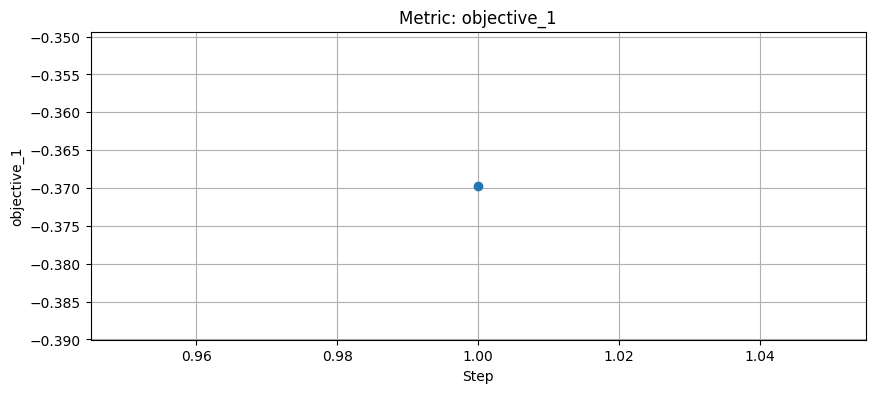

In [26]:
searcher.visualize_results()

## Conclusion

In this notebook, we walked through the process of setting up and executing a cross-lingual evolutionary merging experiment using the Mergenetic library. 

You can now experiment with different configurations, merging methods, or optimization parameters to further explore cross-lingual model merging.

**Happy merging!**